In [1]:
# Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, RandomizedSearchCV, learning_curve, validation_curve, TimeSeriesSplit
import xgboost as xgb
import lightgbm as lgb
import warnings
import joblib
import json

warnings.filterwarnings('ignore')

# Configuration du style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
# Options: "grid" (lent) ou "random" (rapide)
SEARCH_MODE = "random" 
# Nombre de combinaisons à tester pour l'optimisation
N_RANDOM_SAMPLES = 200 

In [3]:
# Chargement dataset
df = pd.read_csv("../data/dataset_ml_prepared.csv")

In [4]:
# Aperçu
df.head()

,user_id,mois,depense_totale,depense_prev,target,salaire,loyer,nb_enfants,conso_factor,month,quarter,year,periode_fetes,time_idx,profil_code,tier_code,lag_1,lag_2,lag_3,rolling_mean_3
0,1,2020-05-01,2315.965943,2227.944459,2406.175426,2025,605,3,1.9,5,2,2020,0,3,2,2,2227.944459,2280.959964,2583.554464,2364.152962
1,1,2020-06-01,2406.175426,2315.965943,2402.397344,2025,605,3,1.9,6,2,2020,0,4,2,2,2315.965943,2227.944459,2280.959964,2274.956789
2,1,2020-07-01,2402.397344,2406.175426,2828.328576,2025,605,3,1.9,7,3,2020,0,5,2,2,2406.175426,2315.965943,2227.944459,2316.695276
3,1,2020-08-01,2828.328576,2402.397344,1574.711335,2025,605,3,1.9,8,3,2020,0,6,2,2,2402.397344,2406.175426,2315.965943,2374.846238
4,1,2020-09-01,1574.711335,2828.328576,2531.992039,2025,605,3,1.9,9,3,2020,0,7,2,2,2828.328576,2402.397344,2406.175426,2545.633782


In [5]:
# Définition de la Cible (Y)
TARGET = "target" 

# Définition des Caractéristiques (X)
FEATURES = [
    "depense_totale", "depense_prev",
    "lag_1", "lag_2", "lag_3", "rolling_mean_3",
    "salaire", "loyer", "nb_enfants",
    "profil_code", "tier_code",
    "month", "quarter", "periode_fetes", "time_idx"
    #'user_id' a été retiré ici pour éviter l'overfitting
]

df["mois"] = pd.to_datetime(df["mois"])
df = df.sort_values("mois") # S'assurer que le DataFrame est trié chronologiquement

X = df[FEATURES]
y = df[TARGET]

### Découpe chronologique

In [6]:
# Mois max
max_date = df["mois"].max()

# Validation Cutoff: Période avant-dernière (pour ajuster les hyperparamètres)
# Le jeu de Validation sera les 3 mois juste après cette date.
validation_cutoff = max_date - pd.DateOffset(months=5) 

# Test Cutoff: Dernière période (réservée pour l'évaluation finale)
# Le jeu de Test sera les 2 derniers mois après cette date.
test_cutoff = max_date - pd.DateOffset(months=2) 

# Découpe des jeux de données
X_train = X[df["mois"] <= validation_cutoff]
y_train = y[df["mois"] <= validation_cutoff]

X_val = X[(df["mois"] > validation_cutoff) & (df["mois"] <= test_cutoff)]
y_val = y[(df["mois"] > validation_cutoff) & (df["mois"] <= test_cutoff)]

X_test = X[df["mois"] > test_cutoff]
y_test = y[df["mois"] > test_cutoff]

print(f"Période Train max: {validation_cutoff.strftime('%Y-%m')}")
print(f"Période Validation (Val) : {test_cutoff.strftime('%Y-%m')}")
print(f"Période Test (Test) max: {max_date.strftime('%Y-%m')}")

print("\n--- Tailles des jeux ---")
print(f"Train:     {X_train.shape}")
print(f"Validation: {X_val.shape}")
print(f"Test:       {X_test.shape}")

Période Train max: 2024-07
Période Validation (Val) : 2024-10
Période Test (Test) max: 2024-12

--- Tailles des jeux ---
Train:     (76500, 15)
Validation: (4500, 15)
Test:       (3000, 15)


### GRILLES DE PARAMÈTRES

In [7]:
# GRILLES DE PARAMÈTRES (Hyperparamètres)
def create_dense_param_grid_xgb():
    """Grille pour XGBoost."""
    return {
        'n_estimators': np.arange(100, 1001, 100).tolist(),
        'learning_rate': np.round(np.logspace(-3, -0.5, 10), 4).tolist(),
        'max_depth': list(range(3, 11)),
        'subsample': np.round(np.linspace(0.6, 1.0, 10), 2).tolist(),
        'colsample_bytree': np.round(np.linspace(0.6, 1.0, 10), 2).tolist(),
        'reg_alpha': [0, 0.01, 0.1, 0.5, 1.0],
        'reg_lambda': [0.5, 1.0, 2.0, 5.0]
    }

def create_dense_param_grid_lgb():
    """Grille pour LightGBM"""
    return {
        'n_estimators': [500, 800, 1000, 1500, 2000], #np.arange(200, 1201, 200).tolist(),
        'learning_rate': [0.05, 0.01, 0.005, 0.001], #np.round(np.logspace(-3, -0.5, 8), 4).tolist(),
        'num_leaves': [15, 20, 31, 40, 50], #[15, 31, 50, 63, 80], # Cœur de la complexité LGBM
        # 'max_depth' retiré pour simplifier la recherche (LGBM préfère num_leaves)
        'subsample': np.round(np.linspace(0.7, 1.0, 5), 2).tolist(), #np.round(np.linspace(0.6, 1.0, 8), 2).tolist(),
        'colsample_bytree': np.round(np.linspace(0.7, 1.0, 5), 2).tolist(), #np.round(np.linspace(0.6, 1.0, 8), 2).tolist(),
        'min_child_samples': [20, 50, 100], #[10, 20, 50],
        'min_data_in_leaf': [50, 100, 200, 500], #[20, 50, 100, 200, 500],
        'min_split_gain': [0.0, 0.1, 0.2, 0.5, 1.0],
        'reg_alpha': [0.5, 1.0, 5.0, 10.0, 20.0], #[0, 0.01, 0.1, 0.5, 1.0],
        'reg_lambda': [1.0, 5.0, 10.0, 20.0, 50.0], #[0.5, 1.0, 2.0, 5.0]
    }

xgb_param_grid = create_dense_param_grid_xgb()
lgb_param_grid = create_dense_param_grid_lgb()


def evaluate_on_set(model, X_set, y_set, prefix=""):
    """
    Calcule les métriques d'évaluation pour un modèle sur un jeu de données spécifique.
    Le prefixe ('train', 'val', 'test') permet de différencier les scores.
    """
    y_pred = model.predict(X_set)
    metrics = {
        f'{prefix}_mae': mean_absolute_error(y_set, y_pred),
        f'{prefix}_rmse': np.sqrt(mean_squared_error(y_set, y_pred)),
        f'{prefix}_r2': r2_score(y_set, y_pred),
        f'{prefix}_mape': np.mean(np.abs((y_set - y_pred) / y_set)) * 100
    }
    return metrics, y_pred

### Recherche d'Hyperparamètres et Cross-validation

In [8]:
def search_hyperparameters(model_type, param_grid, X_train, y_train, X_val, y_val, n_samples):
    """Effectue une recherche aléatoire intelligente avec TimeSeriesSplit."""

    if len(param_grid) == 0 or n_samples == 0:
        return {}

    if model_type == 'XGBoost':
        model_base = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    else:
        model_base = lgb.LGBMRegressor(random_state=42, verbose=-1)

    print(f"\nDébut de la recherche d'hyperparamètres ({SEARCH_MODE}) pour {model_type}...")

    # Utilisation de TimeSeriesSplit, le standard pour les données temporelles
    # Il garantit que chaque split de CV(cross-validation) est chronologique, sans fuite future.
    tscv = TimeSeriesSplit(n_splits=5)

    search_algo = RandomizedSearchCV(
        estimator=model_base,
        param_distributions=param_grid,
        n_iter=n_samples,
        # Optimisation sur le MAE NÉGATIF (plus proche de zéro est meilleur)
        scoring='neg_mean_absolute_error', 
        cv=tscv, # Utilisation du TimeSeriesSplit
        verbose=1,
        n_jobs=-1,
        random_state=42
    )

    # Entraînement de la recherche sur le TRAIN SET (avec la CV temporelle)
    search_algo.fit(X_train, y_train)

    best_model = search_algo.best_estimator_

    # Évaluation du meilleur modèle sur le JEU DE VALIDATION (X_val)
    metrics_val, y_pred_val = evaluate_on_set(best_model, X_val, y_val, prefix="val")
    # Évaluation sur le JEU D'ENTRAÎNEMENT (X_train) pour détection d'overfitting
    metrics_train, _ = evaluate_on_set(best_model, X_train, y_train, prefix="train")

    best_result = {
        'model_type': model_type,
        'params': search_algo.best_params_,
        'model': best_model,
        'cv_score': search_algo.best_score_, # MAE moyen sur les 5 folds(plis/portions)
        **metrics_train,
        **metrics_val,
        'y_pred_val': y_pred_val
    }

    print(f"\n{model_type} - MAE Validation: {best_result['val_mae']:.2f}€ | MAE Train: {best_result['train_mae']:.2f}€")
    print(f"Meilleurs paramètres: {best_result['params']}")

    return best_result


# Lancement de la nouvelle recherche d'hyperparamètres
print("\n" + "="*70)
print("DÉBUT DE L'OPTIMISATION DES HYPERPARAMÈTRES")
print("="*70 + "\n")

best_xgb_result = search_hyperparameters('XGBoost', xgb_param_grid, X_train, y_train, X_val, y_val, N_RANDOM_SAMPLES)
best_lgb_result = search_hyperparameters('LightGBM', lgb_param_grid, X_train, y_train, X_val, y_val, N_RANDOM_SAMPLES)

# Comparaison finale
if best_xgb_result['val_mae'] < best_lgb_result['val_mae']:
    final_winner_result = best_xgb_result
    print("\nLe modèle XGBoost a le meilleur score MAE sur le jeu de Validation.")
else:
    final_winner_result = best_lgb_result
    print("\nLe modèle LightGBM a le meilleur score MAE sur le jeu de Validation.")


DÉBUT DE L'OPTIMISATION DES HYPERPARAMÈTRES


Début de la recherche d'hyperparamètres (random) pour XGBoost...
Fitting 5 folds for each of 200 candidates, totalling 1000 fits

XGBoost - MAE Validation: 208.64€ | MAE Train: 190.25€
Meilleurs paramètres: {'subsample': 0.96, 'reg_lambda': 0.5, 'reg_alpha': 0.1, 'n_estimators': 1000, 'max_depth': 7, 'learning_rate': 0.0068, 'colsample_bytree': 0.91}

Début de la recherche d'hyperparamètres (random) pour LightGBM...
Fitting 5 folds for each of 200 candidates, totalling 1000 fits

LightGBM - MAE Validation: 205.61€ | MAE Train: 190.89€
Meilleurs paramètres: {'subsample': 0.85, 'reg_lambda': 10.0, 'reg_alpha': 0.5, 'num_leaves': 40, 'n_estimators': 500, 'min_split_gain': 0.0, 'min_data_in_leaf': 500, 'min_child_samples': 20, 'learning_rate': 0.05, 'colsample_bytree': 1.0}

Le modèle LightGBM a le meilleur score MAE sur le jeu de Validation.


### Fonction de diagnostic

In [9]:
# FONCTIONS DE DIAGNOSTIC

def plot_learning_curve(estimator, title, X, y, axes=None, cv=None, n_jobs=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    """Génère un plot de la courbe d'apprentissage."""
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(10, 5))

    axes.set_title(title, fontweight='bold')
    axes.set_xlabel("Taille du jeu d'entraînement (nombre d'échantillons)")
    axes.set_ylabel("Score (Négatif MAE)") # La métrique utilisée pour l'optimisation

    # Calcule les scores d'entraînement et de validation pour différentes tailles de dataset
    train_sizes, train_scores, test_scores, _, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       scoring='neg_mean_absolute_error',
                       return_times=True)

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    # Courbe d'entraînement (en Rouge)
    axes.grid(alpha=0.3)
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
              label="Score d'entraînement")
    
    # Courbe de cross-validation (en Vert)
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
              label="Score de Cross-Validation")
    axes.legend(loc="best")
    return plt

def plot_validation_curve(estimator, title, X, y, param_name, param_range,
                          scoring='neg_mean_absolute_error', cv=None, n_jobs=None):
    """Génère un plot de la courbe de validation pour un seul hyperparamètre."""
    
    # Calcule les scores pour chaque valeur du paramètre
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=n_jobs
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title(title, fontweight='bold')
    plt.xlabel(param_name)
    plt.ylabel("Score (Négatif MAE)")
    plt.plot(param_range, train_scores_mean, label="Score d'entraînement", color="r")
    plt.plot(param_range, test_scores_mean, label="Score de Cross-Validation", color="g")
    
    # Ligne pour le meilleur score trouvé
    plt.hlines(test_scores_mean.max(), param_range.min(), param_range.max(), color='k', linestyle='--', label='Meilleure performance CV')

    plt.legend(loc="best")
    plt.grid(alpha=0.3)
    plt.show()

#### Learning curve


Génération de la Courbe d'Apprentissage pour le modèle gagnant...


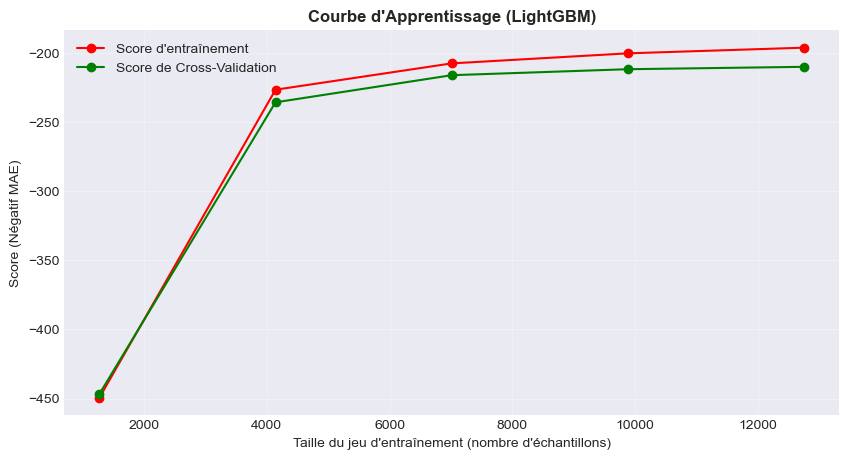

In [10]:
# Courbe d'Apprentissage (Learning Curve)
print("\nGénération de la Courbe d'Apprentissage pour le modèle gagnant...")
# Réutilisation du TimeSeriesSplit (tscv)
tscv = TimeSeriesSplit(n_splits=5) 
model_for_lc = final_winner_result['model']

plot_learning_curve(model_for_lc,
                    f"Courbe d'Apprentissage ({final_winner_result['model_type']})",
                    X_train, y_train, cv=tscv, n_jobs=-1)
plt.show()

#### Validation Curve


Génération de la Courbe de Validation pour l'hyperparamètre de complexité...


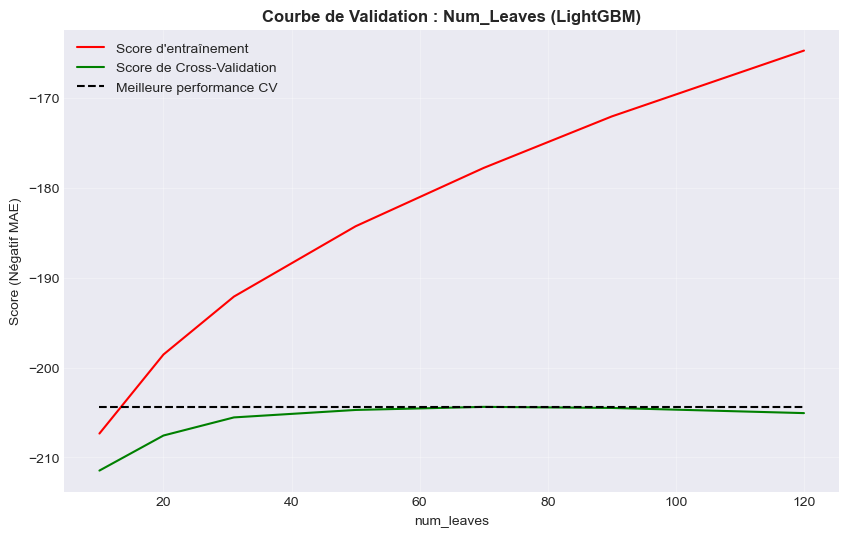

In [11]:
# Courbe de Validation (Validation Curve)
print("\nGénération de la Courbe de Validation pour l'hyperparamètre de complexité...")

model_type = final_winner_result['model_type']
# On utilise un estimateur de base pour ne pas re-calculer les paramètres optimaux,
# car validation_curve teste l'impact d'un seul paramètre.
model_base = xgb.XGBRegressor(objective='reg:squarederror', random_state=42) if model_type == 'XGBoost' else lgb.LGBMRegressor(random_state=42, verbose=-1)

if model_type == 'XGBoost':
    # Variation de la profondeur des arbres (max_depth)
    param_range = np.arange(1, 15, 1)
    plot_validation_curve(model_base,
                          f"Courbe de Validation : Max_Depth ({model_type})",
                          X_train, y_train,
                          param_name="max_depth",
                          param_range=param_range,
                          cv=tscv, n_jobs=-1)
else: # LightGBM
    # Variation du nombre de feuilles (num_leaves)
    param_range = np.array([10, 20, 31, 50, 70, 90, 120])
    plot_validation_curve(model_base,
                          f"Courbe de Validation : Num_Leaves ({model_type})",
                          X_train, y_train,
                          param_name="num_leaves",
                          param_range=param_range,
                          cv=tscv, n_jobs=-1)

### Évaluation Finale et Sauvegarde

In [12]:
# ÉVALUATION FINALE SUR LE JEU DE TEST (X_test, y_test)
print("\n" + "="*70)
print("ÉVALUATION FINALE SUR LE JEU DE TEST RÉSERVÉ")
print("="*70)

# Le modèle a déjà été entraîné lors de la recherche sur X_train
final_model = final_winner_result['model']

# Évaluation sur le Test Set
metrics_test, y_pred_test = evaluate_on_set(final_model, X_test, y_test, prefix="test")

# Mise à jour du dictionnaire de résultats
final_winner_result.update(metrics_test)
final_winner_result['y_pred_test'] = y_pred_test 

print(f"\nModèle Final: {final_winner_result['model_type']}")
print(f"MAE sur le Test Set:   {final_winner_result['test_mae']:.2f}€")
print(f"RMSE sur le Test Set:  {final_winner_result['test_rmse']:.2f}€")
print(f"R² sur le Test Set:    {final_winner_result['test_r2']:.4f}")
print(f"MAPE sur le Test Set:  {final_winner_result['test_mape']:.2f}%")


ÉVALUATION FINALE SUR LE JEU DE TEST RÉSERVÉ

Modèle Final: LightGBM
MAE sur le Test Set:   198.60€
RMSE sur le Test Set:  283.98€
R² sur le Test Set:    0.9452
MAPE sur le Test Set:  8.13%



Génération des visualisations de prédictions finales...


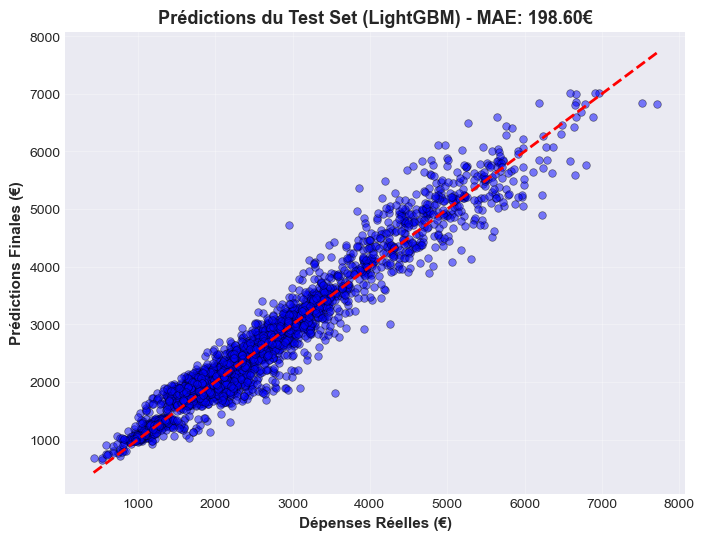

In [13]:
# Visualisation des Prédictions du Test Set (Scatter Plot)
print("\nGénération des visualisations de prédictions finales...")

plt.figure(figsize=(8, 6))
# Nuage de points: Réel (X) vs Prédit (Y). Idéalement, les points sont sur la ligne rouge.
plt.scatter(y_test, y_pred_test, alpha=0.5, s=30, color='b', edgecolors='k', linewidth=0.5)
# Ligne rouge idéale (y=x)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Dépenses Réelles (€)', fontsize=11, fontweight='bold')
plt.ylabel('Prédictions Finales (€)', fontsize=11, fontweight='bold')
plt.title(f'Prédictions du Test Set ({final_winner_result["model_type"]}) - MAE: {final_winner_result["test_mae"]:.2f}€', fontsize=13, fontweight='bold')
plt.grid(alpha=0.3)
plt.show()

In [14]:
# SAUVEGARDE FINALE DU MODÈLE ET DES MÉTRADONNÉES
model_name = final_winner_result['model_type'].lower()

# Sauvegarder le modèle (pickle)
joblib.dump(final_model, f'../model/best_financial_model_{model_name}_optimized.pkl')

# Fonction utilitaire pour convertir en float natif de Python
def to_float(value):
    if isinstance(value, (int, float, np.generic)):
        return float(value)
    if isinstance(value, dict):
        return {k: to_float(v) for k, v in value.items()}
    return value

metadata = {
    'model_type': model_name,
    'features': FEATURES, # Utilisation des features sans 'user_id'
    'best_params': to_float(final_winner_result['params']),
    'train_cutoff': validation_cutoff.strftime('%Y-%m'),
    'validation_cutoff': test_cutoff.strftime('%Y-%m'),
    # Métriques complètes pour la traçabilité
    'metrics_test': {
        'mae': to_float(final_winner_result['test_mae']),
        'rmse': to_float(final_winner_result['test_rmse']),
        'r2': to_float(final_winner_result['test_r2']),
        'mape': to_float(final_winner_result['test_mape'])
    },
    'metrics_validation': {
        'mae': to_float(final_winner_result['val_mae']),
        'rmse': to_float(final_winner_result['val_rmse']),
        'r2': to_float(final_winner_result['val_r2']),
        'mape': to_float(final_winner_result['val_mape'])
    }
}

with open(f'../model/model_metadata_{model_name}_optimized.json', 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"\nModèle {model_name} optimisé et évalué (MAE Test: {final_winner_result['test_mae']:.2f}€) sauvegardé avec succès!")
print("="*70)


Modèle lightgbm optimisé et évalué (MAE Test: 198.60€) sauvegardé avec succès!
